In [1]:
!pip install librosa

  Using cached https://files.pythonhosted.org/packages/68/64/1191352221e2ec90db7492b4bf0c04fd9d2508de67b3f39cbf093cd6bd86/SoundFile-0.10.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8f/42/155696f85f344c066e17af287359c9786b436b1bf86029bb3411283274f3/joblib-0.14.0-py2.py3-none-any.whl


In [2]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
import h5py
import librosa
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from collections import OrderedDict

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


# Read the data

> Helper functions to assist the process to read songs, split then and return an array of spectrograms/melspectrograms

In [3]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.1, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [3]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft = 1024, hop_length = 512):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft = n_fft,
        hop_length = hop_length)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    return np.array(list(tsongs))

In [5]:
def read_data(src_dir, genres, song_samples, spec_format, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_specs = []
    arr_genres = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        print(folder)
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                print(file_name)
                signal, sr = librosa.load(file_name)
                signal = signal[:song_samples]
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Convert to dataset of spectograms/melspectograms
                signals, y = splitsongs(signal, genres[x])
                
                # Convert to "spec" representation
                specs = spec_format(signals)
                
                # Save files
                arr_genres.extend(y)
                arr_specs.extend(specs)
                
                
    return np.array(arr_specs), np.array(arr_genres)

In [6]:
# Parameters
gtzan_dir = '../Final_report/gtzan_training/genres/'
song_samples = 660000
genres = {'classical': 2, 'hiphop': 3, 'jazz': 4, 'blues': 7, 'rock': 9}

In [7]:
# Read the data
X, y = read_data(gtzan_dir, genres, song_samples, to_melspectrogram, debug=False)
np.save('x_gtzan_npy_v6.npy', X)
np.save('y_gtzan_npy_v6.npy', y)

../Final_report/gtzan_training/genres/classical
../Final_report/gtzan_training/genres/classical/classical.00013.wav
../Final_report/gtzan_training/genres/classical/classical.00077.wav
../Final_report/gtzan_training/genres/classical/classical.00045.wav
../Final_report/gtzan_training/genres/classical/classical.00076.wav
../Final_report/gtzan_training/genres/classical/classical.00041.wav
../Final_report/gtzan_training/genres/classical/classical.00015.wav
../Final_report/gtzan_training/genres/classical/classical.00039.wav
../Final_report/gtzan_training/genres/classical/classical.00024.wav
../Final_report/gtzan_training/genres/classical/classical.00007.wav
../Final_report/gtzan_training/genres/classical/classical.00067.wav
../Final_report/gtzan_training/genres/classical/classical.00062.wav
../Final_report/gtzan_training/genres/classical/classical.00052.wav
../Final_report/gtzan_training/genres/classical/classical.00038.wav
../Final_report/gtzan_training/genres/classical/classical.00055.wav


In [8]:
X = np.load('x_gtzan_npy_v6.npy')
y = np.load('y_gtzan_npy_v6.npy')

In [9]:
# One hot encoding of the labels
y = to_categorical(y)

# Dataset Split

In [10]:
X_stack = np.squeeze(np.stack((X,) * 3, -1))
X_stack.shape

(8550, 128, 129, 3)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_stack, y, test_size=0.1, random_state=42, stratify = y)

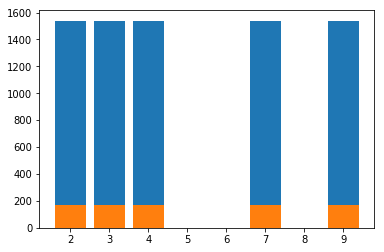

In [12]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

# Training

In [13]:
# Model Definition
input_shape = X_train[0].shape
num_genres = 10

def cnn_vgg16(input_shape, num_genres, freezed_layers):
    input_tensor = Input(shape=input_shape)
    vgg16 = VGG16(include_top=False, weights='imagenet',
                  input_tensor=input_tensor)

    top = Sequential()
    top.add(Flatten(input_shape=vgg16.output_shape[1:]))
    top.add(Dense(256, activation='relu'))
    top.add(Dropout(0.5))
    top.add(Dense(num_genres, activation='softmax'))

    model = Model(inputs=vgg16.input, outputs=top(vgg16.output))
    for layer in model.layers[:freezed_layers]:
        layer.trainable = False

    return model

model = cnn_vgg16(input_shape, num_genres, 5)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 129, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 129, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 129, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [14]:
model_path = '../Final_report/models/nbs_vgg16_v6.h5'

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
batch_size = 128
epochs = 30


In [15]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

hist = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks = [checkpoint, earlystop])

Train on 7695 samples, validate on 855 samples
Epoch 1/30
7695/7695 [==============================] - 18s 2ms/step - loss: 1.8191 - acc: 0.3832 - val_loss: 1.2123 - val_acc: 0.4526

Epoch 00001: val_loss improved from inf to 1.21227, saving model to ../Final_report/models/nbs_vgg16_v6.h5
Epoch 2/30
7695/7695 [==============================] - 13s 2ms/step - loss: 1.0517 - acc: 0.5686 - val_loss: 0.7973 - val_acc: 0.7006

Epoch 00002: val_loss improved from 1.21227 to 0.79730, saving model to ../Final_report/models/nbs_vgg16_v6.h5
Epoch 3/30
7695/7695 [==============================] - 14s 2ms/step - loss: 0.8552 - acc: 0.6680 - val_loss: 0.7073 - val_acc: 0.7345

Epoch 00003: val_loss improved from 0.79730 to 0.70726, saving model to ../Final_report/models/nbs_vgg16_v6.h5
Epoch 4/30
7695/7695 [==============================] - 13s 2ms/step - loss: 0.7668 - acc: 0.7129 - val_loss: 0.9459 - val_acc: 0.5778

Epoch 00004: val_loss did not improve from 0.70726
Epoch 5/30
7695/7695 [=======

In [16]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 0.202 and val_acc = 0.930


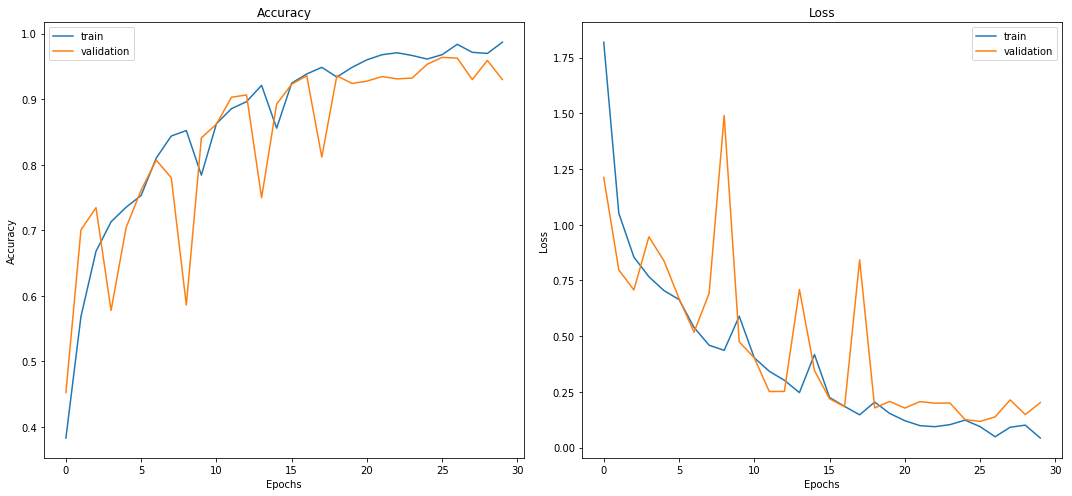

In [17]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


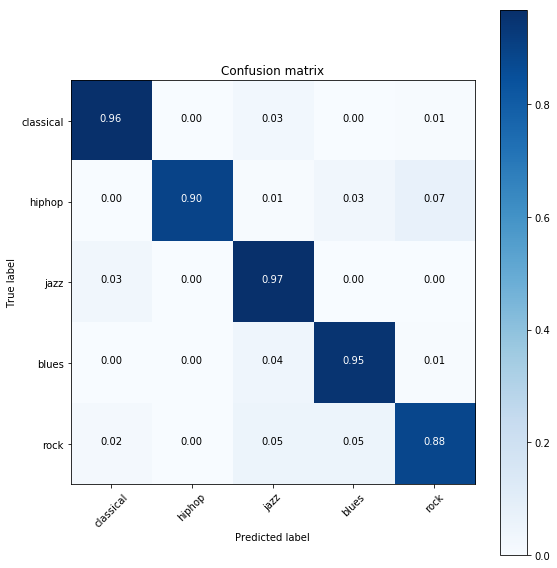

In [20]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)

## Save the model

In [21]:
# Save the model
# model.save('../Final_report/models/nbs_vgg16_v6.h5')

## Test data process

In [4]:
#load model
model = load_model('../Final_report/models/nbs_vgg16_v6.h5')

In [5]:
# Parameters
# test_dir = '../Final_report/test_data'
test_dir = '../Final_report/gtzan_testing'
song_samples = 660000

In [6]:
def create_filename_list(src_dir):
    filename_list = []
    for root, subdirs, files in os.walk(src_dir):
        for file in files:
            filename_list.append(file)
    return filename_list

In [7]:
def read_test_data(src_dir, song_samples, spec_format):
    arr_specs = []
    music_splits_len = []
    
    for root, subdirs, files in os.walk(src_dir):
        for file in files:
            file_name = src_dir + "/" + file
            signal, sr = librosa.load(file_name)
            
#             target_samples = signal.shape[0] - (signal.shape[0] % sr)
            signal = signal[:song_samples]
                        
            # Convert to dataset of spectograms/melspectograms
            signals = splitsongs_for_test(signal, music_splits_len)
                
            # Convert to "spec" representation
            specs = spec_format(signals)
                
            # Save files
            arr_specs.extend(specs)
    return np.array(arr_specs), music_splits_len

In [8]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs_for_test(X, music_splits_len, window = 0.1, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
    music_splits_len.append(len(temp_X))
    return np.array(temp_X)

In [9]:
test_x, music_splits_len = read_test_data(test_dir, song_samples, to_melspectrogram)

In [28]:
# Read the data
np.save('test_x_v6_npy.npy', test_x)

In [10]:
X_test = np.load('test_x_v6_npy.npy')

In [11]:
X_test_stack = np.squeeze(np.stack((X_test,) * 3, -1))

In [12]:
predict_result = model.predict(X_test_stack)

In [13]:
def group_predict_result(predict_result, music_splits_len):
    grouping_predict_result = []
    delete_result = predict_result
    for length in music_splits_len:
        temp_grouping = []
        for i in range(length):
            temp_grouping.append(delete_result[0])
            delete_result = np.delete(delete_result, [0], axis=0)
        grouping_predict_result.append(temp_grouping)
    return grouping_predict_result

In [14]:
def most_frequent(List): 
    counter = 0
    num = List[0]
    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i
    return num

In [15]:
def get_predict_result(grouping_predict):
    final_result = []
    for group in grouping_predict:
        group_indexs = []
        for item in group:
            max = np.argmax(item, axis=0)
            group_indexs.append(max.tolist())
        max_duplicated_value = most_frequent(group_indexs)
        final_result.append(max_duplicated_value)
    return final_result

In [16]:
grouping_predict = group_predict_result(predict_result, music_splits_len)

In [17]:
final_predict = get_predict_result(grouping_predict)

In [18]:
filename_list = create_filename_list(test_dir)

In [19]:
predict = pd.DataFrame({"id":filename_list, "class":final_predict})

In [39]:
predict.to_csv("v6_submission.csv", index = False)

In [20]:
predict

,id,class
0,jazz.00098.wav,4
1,blues.00092.wav,7
2,classical.00095.wav,2
3,classical.00096.wav,2
4,blues.00093.wav,7
5,hiphop.00099.wav,3
6,classical.00098.wav,2
7,rock.00091.wav,9
8,classical.00099.wav,2
9,jazz.00095.wav,4


In [21]:
genres = {'classical': 2, 'hiphop': 3, 'jazz': 4, 'blues': 7, 'rock': 9}

In [22]:
def getLables():
    labels = []
    for filename in filename_list:
        str_list = filename.split('.')
        labels.append(str_list[0])
    return labels

In [23]:
labels = getLables()

In [24]:
solution = pd.DataFrame({"id":filename_list, "class":labels})

In [25]:
mapping = genres

In [26]:
solution['class'] = solution['class'].map(mapping)

In [27]:
total_count = len(solution['class'])

In [28]:
def caculate_accuracy(total_count):
    correct = 0
    for i in range(total_count):
        print('==============================================================')
        print('solution index ' + str(i) + ' = ' + str(solution['class'][i]))
        print('predict index ' + str(i) + ' = ' + str(predict['class'][i]))
        if(solution['class'][i] == predict['class'][i]):
            print('predict correct')
            correct += 1
    return correct / total_count

In [29]:
caculate_accuracy(total_count)

solution index 0 = 4
predict index 0 = 4
predict correct
solution index 1 = 7
predict index 1 = 7
predict correct
solution index 2 = 2
predict index 2 = 2
predict correct
solution index 3 = 2
predict index 3 = 2
predict correct
solution index 4 = 7
predict index 4 = 7
predict correct
solution index 5 = 3
predict index 5 = 3
predict correct
solution index 6 = 2
predict index 6 = 2
predict correct
solution index 7 = 9
predict index 7 = 9
predict correct
solution index 8 = 2
predict index 8 = 2
predict correct
solution index 9 = 4
predict index 9 = 4
predict correct
solution index 10 = 7
predict index 10 = 7
predict correct
solution index 11 = 3
predict index 11 = 3
predict correct
solution index 12 = 7
predict index 12 = 7
predict correct
solution index 13 = 4
predict index 13 = 4
predict correct
solution index 14 = 4
predict index 14 = 4
predict correct
solution index 15 = 9
predict index 15 = 9
predict correct
solution index 16 = 3
predict index 16 = 3
predict correct
solution index 17

0.9

In [31]:
predict['ground_truth'] = solution['class']

In [32]:
predict

,id,class,ground_truth
0,jazz.00098.wav,4,4
1,blues.00092.wav,7,7
2,classical.00095.wav,2,2
3,classical.00096.wav,2,2
4,blues.00093.wav,7,7
5,hiphop.00099.wav,3,3
6,classical.00098.wav,2,2
7,rock.00091.wav,9,9
8,classical.00099.wav,2,2
9,jazz.00095.wav,4,4


In [37]:
def get_predict_list():
    predict_list = []
    for i in range(total_count):
        predict_result = False
        if(solution['class'][i] == predict['class'][i]):
            predict_result = True
        predict_list.append(predict_result)
    return predict_list

In [40]:
predict['predict_correct'] = get_predict_list()

In [41]:
predict

,id,class,ground_truth,predict_result,predict_correct
0,jazz.00098.wav,4,4,True,True
1,blues.00092.wav,7,7,True,True
2,classical.00095.wav,2,2,True,True
3,classical.00096.wav,2,2,True,True
4,blues.00093.wav,7,7,True,True
5,hiphop.00099.wav,3,3,True,True
6,classical.00098.wav,2,2,True,True
7,rock.00091.wav,9,9,True,True
8,classical.00099.wav,2,2,True,True
9,jazz.00095.wav,4,4,True,True


In [42]:
predict.to_csv("predict_result.csv", index = False)